# Correlating well log pairs: Complex Dynamic Time Warping with boundary constraints

## Introduction to dynamic time warping

In [31]:
# Data manipulation and analysis
import os
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import glob
from IPython.display import Image as IPImage, display
from scipy import stats
from matplotlib.lines import Line2D
warnings.filterwarnings('ignore')

from pyCoreRelator import (
    run_comprehensive_dtw_analysis,
    find_complete_core_paths,
    load_log_data,
    plot_core_data,
    plot_correlation_distribution,
    load_core_age_constraints
)

<hr>

### Test with Cascadia hi-res MS logs

### Define core pairs

In [32]:
# Define core names as variables for easy reference
# CORE_A = "M9907-22PC"
# CORE_A = "M9907-23PC"
CORE_A = "M9907-11PC"
# CORE_A = "RR0207-56PC" 

# CORE_B = "M9907-25PC"
CORE_B = "M9907-12PC"
# CORE_B = "RR0207-56PC" 

#### Data structures and core images

In [33]:
# Define log columns to extract
# LOG_COLUMNS = ['hiresMS', 'CT', 'R', 'G', 'B']  # Choose which logs to include
# LOG_COLUMNS = ['hiresMS', 'CT', 'Lumin']  # Choose which logs to include
LOG_COLUMNS = ['hiresMS']  # Choose which logs to include
DEPTH_COLUMN = 'SB_DEPTH_cm'

# Define directory paths
mother_dir = '/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/OSU_dataset/'

# Define paths for Core A
core_a_log_paths = {
    'hiresMS': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_hiresMS_MLfilled.csv',
    'CT': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_CT_MLfilled.csv',
    'Lumin': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_RGB_MLfilled.csv',
    'R': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_RGB_MLfilled.csv',
    'G': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_RGB_MLfilled.csv',
    'B': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_RGB_MLfilled.csv',
    'Den_gm/cc': f'{mother_dir}_compiled_logs/{CORE_A}/ML_filled/{CORE_A}_MST_MLfilled.csv'
}

core_a_rgb_img_path = f"{mother_dir}_compiled_logs/{CORE_A}/{CORE_A}_RGB.tiff"
core_a_ct_img_path = f"{mother_dir}_compiled_logs/{CORE_A}/{CORE_A}_CT.tiff"

# Define paths for Core B
core_b_log_paths = {
    'hiresMS': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_hiresMS_MLfilled.csv',
    'CT': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_CT_MLfilled.csv',
    'Lumin': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_RGB_MLfilled.csv',
    'R': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_RGB_MLfilled.csv',
    'G': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_RGB_MLfilled.csv',
    'B': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_RGB_MLfilled.csv',
    'Den_gm/cc': f'{mother_dir}_compiled_logs/{CORE_B}/ML_filled/{CORE_B}_MST_MLfilled.csv'
}
core_b_rgb_img_path = f"{mother_dir}_compiled_logs/{CORE_B}/{CORE_B}_RGB.tiff"
core_b_ct_img_path = f"{mother_dir}_compiled_logs/{CORE_B}/{CORE_B}_CT.tiff"

# Define column mapping for alternative column names
column_alternatives = {
    'hiresMS': ['MS'],
    'CT': ['CT_value'],
    'R': ['R', 'red', 'Red'],
    'G': ['G', 'green', 'Green'],
    'B': ['B', 'blue', 'Blue'],
    'Lumin': ['luminance', 'Luminance'],
    'Den_gm/cc': ['Density', 'density']
}

# Load data for Core A
log_a, md_a, available_columns_a, rgb_img_a, ct_img_a = load_log_data(
    core_a_log_paths,
    {'rgb': core_a_rgb_img_path, 'ct': core_a_ct_img_path},
    LOG_COLUMNS,
    depth_column=DEPTH_COLUMN,
    normalize=True,
    column_alternatives=column_alternatives
)

print("\n=== DEBUG: Core A Loading ===")
print(f"LOG_COLUMNS requested: {LOG_COLUMNS}")
print(f"Available columns loaded: {available_columns_a}")
print(f"Shape of log_a: {log_a.shape}")
print(f"Type of log_a: {type(log_a)}")
if hasattr(log_a, 'ndim'):
    print(f"log_a dimensions: {log_a.ndim}")
    if log_a.ndim > 1:
        print(f"log_a has {log_a.shape[1]} columns\n")
    else:
        print("log_a is 1D (single column)\n")

# Load data for Core B
log_b, md_b, available_columns_b, rgb_img_b, ct_img_b = load_log_data(
    core_b_log_paths,
    {'rgb': core_b_rgb_img_path, 'ct': core_b_ct_img_path},
    LOG_COLUMNS,
    depth_column=DEPTH_COLUMN,
    normalize=True,
    column_alternatives=column_alternatives
)

print("\n=== DEBUG: Core B Loading ===")
print(f"LOG_COLUMNS requested: {LOG_COLUMNS}")
print(f"Available columns loaded: {available_columns_b}")
print(f"Shape of log_b: {log_b.shape}")
print(f"Type of log_b: {type(log_b)}")
if hasattr(log_b, 'ndim'):
    print(f"log_b dimensions: {log_b.ndim}")
    if log_b.ndim > 1:
        print(f"log_b has {log_b.shape[1]} columns\n")
    else:
        print("log_b is 1D (single column)\n")

Loaded RGB image
Loaded CT image

=== DEBUG: Core A Loading ===
LOG_COLUMNS requested: ['hiresMS']
Available columns loaded: ['hiresMS']
Shape of log_a: (871,)
Type of log_a: <class 'numpy.ndarray'>
log_a dimensions: 1
log_a is 1D (single column)

Loaded RGB image
Loaded CT image

=== DEBUG: Core B Loading ===
LOG_COLUMNS requested: ['hiresMS']
Available columns loaded: ['hiresMS']
Shape of log_b: (973,)
Type of log_b: <class 'numpy.ndarray'>
log_b dimensions: 1
log_b is 1D (single column)



In [34]:
%matplotlib inline

# Define paths to the CSV files
pickeddepth_a_csv = f'pickeddepth/{CORE_A}_pickeddepth.csv'
pickeddepth_b_csv = f'pickeddepth/{CORE_B}_pickeddepth.csv'

# Load picked depths and categories from CSV files
if os.path.exists(pickeddepth_b_csv):
    picked_data_b = pd.read_csv(pickeddepth_b_csv)
    # Combine depths and categories into tuples
    picked_b = list(zip(picked_data_b['picked_depths_cm'].values.tolist(), 
                        picked_data_b['category'].values.tolist()))
    print(f"Loaded {len(picked_b)} picked depths for {CORE_B}")
else:
    print(f"Warning: {pickeddepth_b_csv} not found. Using empty list for picked_b.")
    picked_b = []

if os.path.exists(pickeddepth_a_csv):
    picked_data_a = pd.read_csv(pickeddepth_a_csv)
    # Combine depths and categories into tuples
    picked_a = list(zip(picked_data_a['picked_depths_cm'].values.tolist(), 
                        picked_data_a['category'].values.tolist()))
    print(f"Loaded {len(picked_a)} picked depths for {CORE_A}")
else:
    print(f"Warning: {pickeddepth_a_csv} not found. Using empty list for picked_a.")
    picked_a = []

# Create uncertainty arrays (assuming uncertainty size is 2 cm)
picked_uncertainty_b = [1] * len(picked_b)
picked_uncertainty_a = [1] * len(picked_a)

Loaded 27 picked depths for M9907-12PC
Loaded 23 picked depths for M9907-11PC


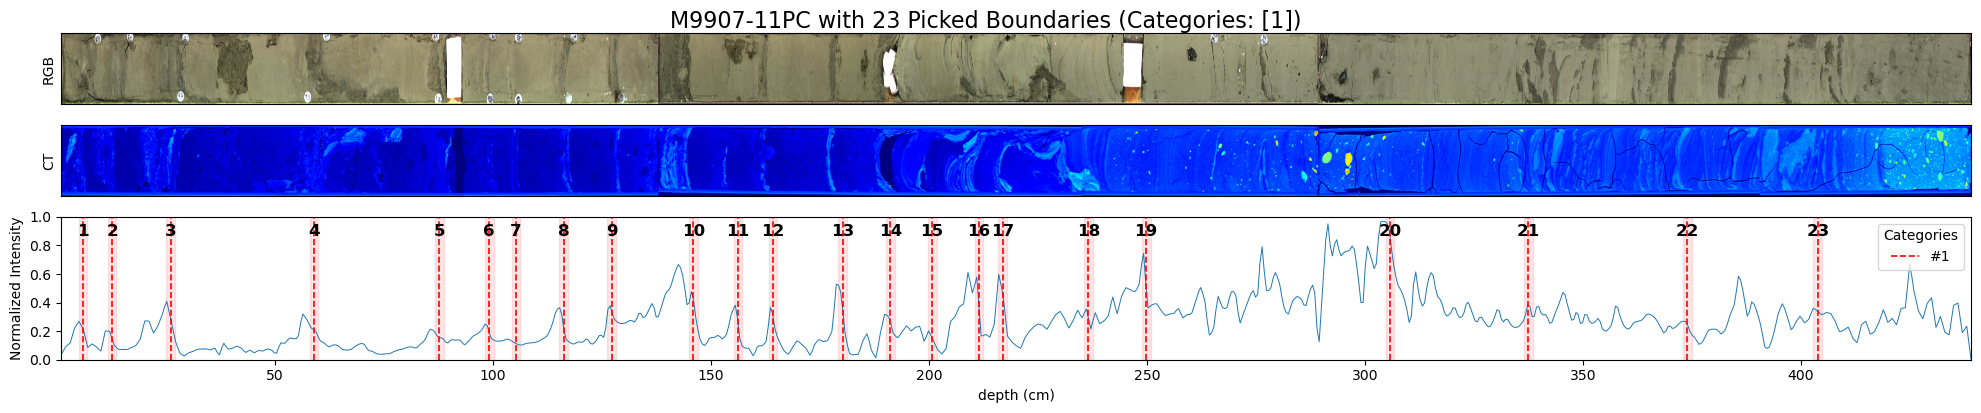

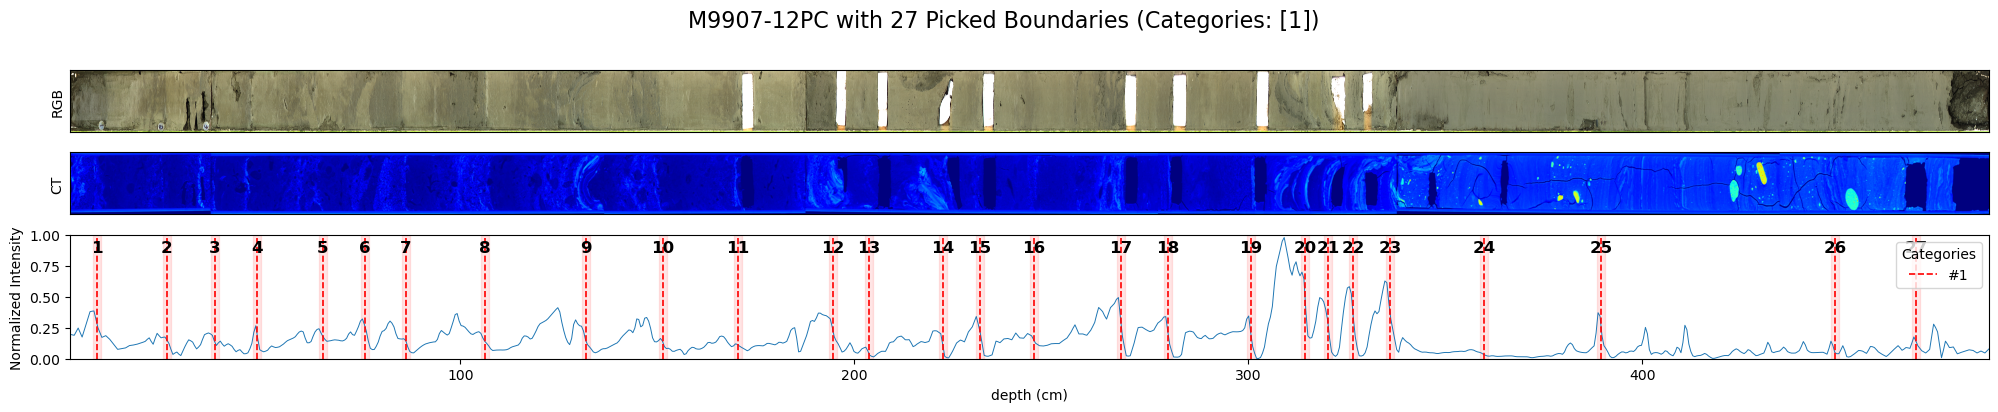

In [35]:
# Extract depths and categories from the loaded tuples
picked_depths_a = [depth for depth, category in picked_a] if picked_a else []
picked_categories_a = [category for depth, category in picked_a] if picked_a else []

picked_depths_b = [depth for depth, category in picked_b] if picked_b else []
picked_categories_b = [category for depth, category in picked_b] if picked_b else []

# Now plot the cores with enhanced plot_core_data function
is_multilog = log_a.ndim > 1 and log_a.shape[1] > 1
fig_a, ax_a = plot_core_data(
    # Input data
    md_a,                                           # depth array
    log_a,                                          # log data array
    f"{CORE_A}",                                    # core name
    # Image data
    rgb_img=rgb_img_a,                              # RGB image array
    ct_img=ct_img_a,                                # CT scan image array
    # Data configuration
    available_columns=available_columns_a,          # available data columns
    is_multilog=is_multilog,                        # multi-column log flag
    # Picked depth data
    picked_depths=picked_depths_a,                  # picked depth values
    picked_categories=picked_categories_a,          # picked categories
    picked_uncertainties=picked_uncertainty_a,      # uncertainty values
    # Visualization settings
    figsize=(20, 4),                                # figure size (width, height)
    show_category=[1],                              # categories to display
    show_bed_number=True                            # show bed numbers flag
)

# Do the same for Core B
is_multilog = log_b.ndim > 1 and log_b.shape[1] > 1
fig_b, ax_b = plot_core_data(
    # Input data
    md_b,                                           # depth array
    log_b,                                          # log data array
    f"{CORE_B}",                                    # core name
    # Image data
    rgb_img=rgb_img_b,                              # RGB image array
    ct_img=ct_img_b,                                # CT scan image array
    # Data configuration
    available_columns=available_columns_b,          # available data columns
    is_multilog=is_multilog,                        # multi-column log flag
    # Picked depth data
    picked_depths=picked_depths_b,                  # picked depth values
    picked_categories=picked_categories_b,          # picked categories
    picked_uncertainties=picked_uncertainty_b,      # uncertainty values
    # Visualization settings
    figsize=(20, 4),                                # figure size (width, height)
    show_category=[1],                              # categories to display
    show_bed_number=True                            # show bed numbers flag
)

plt.tight_layout()
plt.show()

<hr>

# Usage Examples and Executions

In [36]:
# Extract a subset of picked depths of category 1 for both cores
all_depths_a_cat1 = np.array([depth for depth, category in picked_a if category == 1]).astype('float32')
all_depths_b_cat1 = np.array([depth for depth, category in picked_b if category == 1]).astype('float32')

#### extract ages

In [37]:
# Load age constraints for both cores
consider_adjacent_core = True

data_columns = {
    'age': 'calib502_agebp',
    'pos_error': 'calib502_2sigma_pos', 
    'neg_error': 'calib502_2sigma_neg',
    'min_depth': 'mindepth_cm',
    'max_depth': 'maxdepth_cm',
    'in_sequence': 'in_sequence',
    'core': 'core',
    'interpreted_bed': 'interpreted_bed'
}

# Configuration
age_base_path = '/Users/larryslai/Library/CloudStorage/Dropbox/My Documents/University of Texas Austin/(Project) NWP turbidites/Cascadia_core_data/Age constraints/Goldfinger2012'

# Load age constraints for both cores
age_data_a = load_core_age_constraints(CORE_A, age_base_path, consider_adjacent_core, data_columns)
age_data_b = load_core_age_constraints(CORE_B, age_base_path, consider_adjacent_core, data_columns)

uncertainty_method='MonteCarlo'   # 'MonteCarlo', 'Linear', or 'Gaussian'

Loaded 1 age constraints from M9907-11PC_age.csv
Loaded 4 age constraints from M9907-11TC_age.csv
Loaded 10 age constraints from M9907-12PC_age.csv
Loaded 2 age constraints from M9907-12TC_age.csv


In [38]:
# Load estimated boundary age data for both cores from CSV files
cores = [CORE_A, CORE_B]
pickeddepth_ages = {}

for core in cores:
    core_age_csv = f"outputs/{core}_pickeddepth_age_{uncertainty_method}.csv"
    if os.path.exists(core_age_csv):
        df_ages = pd.read_csv(core_age_csv)
        pickeddepth_ages[core] = {
            'depths': df_ages['picked_depths_cm'].values.astype('float32').tolist(),
            'ages': df_ages['est_age'].values.astype('float32').tolist(),
            'pos_uncertainties': df_ages['est_age_poserr'].values.astype('float32').tolist(),
            'neg_uncertainties': df_ages['est_age_negerr'].values.astype('float32').tolist()
        }
        print(f"Loaded estimated boundary age data for {core} from CSV file")
    else:
        print(f"Warning: Could not find boundary age data CSV for {core}")

# Assign to individual variables for backward compatibility
if CORE_A in pickeddepth_ages:
    pickeddepth_ages_a = pickeddepth_ages[CORE_A]
if CORE_B in pickeddepth_ages:
    pickeddepth_ages_b = pickeddepth_ages[CORE_B]


Loaded estimated boundary age data for M9907-11PC from CSV file
Loaded estimated boundary age data for M9907-12PC from CSV file


<hr>

## Compute r-value distribution for all stituation

In [39]:
# Cell: Multi-Parameter Distribution Analysis
# Run all parameter combinations and plot distribution curves together

# Define all parameter combinations to test
parameter_combinations = [
    {'age_consideration': True, 'restricted_age_correlation': True, 'shortest_path_search': False},
    {'age_consideration': True, 'restricted_age_correlation': True, 'shortest_path_search': True},
    {'age_consideration': True, 'restricted_age_correlation': False, 'shortest_path_search': False},
    {'age_consideration': True, 'restricted_age_correlation': False, 'shortest_path_search': True},
    {'age_consideration': False, 'restricted_age_correlation': None, 'shortest_path_search': False},
    {'age_consideration': False, 'restricted_age_correlation': None, 'shortest_path_search': True}
]

# Prepare master CSV file for incremental saving
master_csv_filename = f'outputs/r-values_fit_params_{CORE_A}_{CORE_B}.csv'
os.makedirs('outputs', exist_ok=True)

print(f"Running {len(parameter_combinations)} parameter combinations...")

# Loop through all parameter combinations
for idx, params in enumerate(tqdm(parameter_combinations, desc="Parameter combinations")):
    
    # Extract parameters
    age_consideration = params['age_consideration']
    restricted_age_correlation = params['restricted_age_correlation']
    shortest_path_search = params['shortest_path_search']
    
    # Generate parameter labels for file naming
    if age_consideration:
        if restricted_age_correlation:
            age_label = 'restricted_age'
        else:
            age_label = 'loose_age'
    else:
        age_label = 'no_age'
    
    search_label = 'optimal' if shortest_path_search else 'random'
    
    # Create unique identifier for this combination
    combo_id = f"{age_label}_{search_label}"
    
    # print(f"\n--- Running combination {idx+1}/{len(parameter_combinations)}: {combo_id} ---")
    # print(f"age_consideration={age_consideration}, restricted_age_correlation={restricted_age_correlation}, shortest_path_search={shortest_path_search}")
    
    try:        
        # Run comprehensive DTW analysis
        dtw_results, valid_dtw_pairs, segments_a, segments_b, depth_boundaries_a, depth_boundaries_b, dtw_distance_matrix_full = run_comprehensive_dtw_analysis(
            log_a, log_b, md_a, md_b,
            picked_depths_a=all_depths_a_cat1,
            picked_depths_b=all_depths_b_cat1,
            independent_dtw=False,
            top_bottom=True,
            top_depth=0.0,
            exclude_deadend=True,
            mute_mode=True,
            age_consideration=age_consideration,
            ages_a=pickeddepth_ages_a if age_consideration else None,
            ages_b=pickeddepth_ages_b if age_consideration else None,
            restricted_age_correlation=restricted_age_correlation if age_consideration else False,
            all_constraint_ages_a=age_data_a['in_sequence_ages'] if age_consideration else None,
            all_constraint_ages_b=age_data_b['in_sequence_ages'] if age_consideration else None,
            all_constraint_depths_a=age_data_a['in_sequence_depths'] if age_consideration else None,
            all_constraint_depths_b=age_data_b['in_sequence_depths'] if age_consideration else None,
            all_constraint_pos_errors_a=age_data_a['in_sequence_pos_errors'] if age_consideration else None,
            all_constraint_pos_errors_b=age_data_b['in_sequence_pos_errors'] if age_consideration else None,
            all_constraint_neg_errors_a=age_data_a['in_sequence_neg_errors'] if age_consideration else None,
            all_constraint_neg_errors_b=age_data_b['in_sequence_neg_errors'] if age_consideration else None
        )
        
        # Find complete core paths (only for shortest path search - as requested)
        if shortest_path_search:
            _ = find_complete_core_paths(
                valid_dtw_pairs,
                segments_a,
                segments_b,
                log_a,
                log_b,
                depth_boundaries_a,
                depth_boundaries_b,
                dtw_results,
                output_csv=f'temp_mappings_{CORE_A}_{CORE_B}_{combo_id}.csv',
                start_from_top_only=True,
                batch_size=1000,
                n_jobs=-1,
                shortest_path_search=True,
                shortest_path_level=2,
                max_search_path=100000,
                mute_mode=True
            )
        else:
            # For random search, still run but with different parameters
            _ = find_complete_core_paths(
                valid_dtw_pairs,
                segments_a,
                segments_b,
                log_a,
                log_b,
                depth_boundaries_a,
                depth_boundaries_b,
                dtw_results,
                output_csv=f'temp_mappings_{CORE_A}_{CORE_B}_{combo_id}.csv',
                start_from_top_only=True,
                batch_size=1000,
                n_jobs=-1,
                shortest_path_search=False,
                shortest_path_level=2,
                max_search_path=100000,
                mute_mode=True
            )
        
        # Extract fit_params using plot_correlation_distribution in mute mode
        _, _, fit_params = plot_correlation_distribution(
            csv_file=f'outputs/temp_mappings_{CORE_A}_{CORE_B}_{combo_id}.csv',
            quality_index='corr_coef',
            no_bins=30,
            save_png=False,
            pdf_method='normal',
            kde_bandwidth=0.05,
            mute_mode=True
        )
        
        # Store fit_params with parameter combination info
        if fit_params is not None:
            fit_params_copy = fit_params.copy()
            fit_params_copy['combination_id'] = combo_id
            fit_params_copy['age_consideration'] = age_consideration
            fit_params_copy['restricted_age_correlation'] = restricted_age_correlation
            fit_params_copy['shortest_path_search'] = shortest_path_search
            fit_params_copy['combination_index'] = idx
            
            # Incrementally save to master CSV
            df_single = pd.DataFrame([fit_params_copy])
            if idx == 0:
                # Write header for first combination
                df_single.to_csv(master_csv_filename, mode='w', index=False, header=True)
            else:
                # Append subsequent combinations without header
                df_single.to_csv(master_csv_filename, mode='a', index=False, header=False)

            del df_single, fit_params_copy
        else:
            print(f"✗ No fit_params generated for {combo_id}")
        
        # Clean up temporary files
        if os.path.exists(f'outputs/temp_mappings_{CORE_A}_{CORE_B}_{combo_id}.csv'):
            os.remove(f'outputs/temp_mappings_{CORE_A}_{CORE_B}_{combo_id}.csv')
        
        # Clean up variables and force garbage collection
        del dtw_results, valid_dtw_pairs, segments_a, segments_b
        del depth_boundaries_a, depth_boundaries_b, dtw_distance_matrix_full
        del fit_params
        gc.collect()
        
    except Exception as e:
        print(f"✗ Error in combination {combo_id}: {str(e)}")
        # Clean up on error
        if os.path.exists(f'outputs/temp_mappings_{CORE_A}_{CORE_B}_{combo_id}.csv'):
            os.remove(f'outputs/temp_mappings_{CORE_A}_{CORE_B}_{combo_id}.csv')
        gc.collect()
        continue

print(f"\n✓ Completed all parameter combinations")
print(f"✓ All fit_params saved to: {master_csv_filename}")

Running 6 parameter combinations...


Parameter combinations:  33%|███▎      | 2/6 [05:08<10:16, 154.07s/it]


KeyboardInterrupt: 


--- Creating combined distribution plot ---
Loaded 3 rows after filtering
Loaded parameter combinations:
  age_consideration=False, restricted_age_correlation=None/Empty, shortest_path_search=True (1 rows)
  age_consideration=True, restricted_age_correlation=False, shortest_path_search=True (1 rows)
  age_consideration=True, restricted_age_correlation=True, shortest_path_search=True (1 rows)
Found 3 unique parameter combinations in CSV:
  {'age_consideration': True, 'restricted_age_correlation': True, 'shortest_path_search': True}
  {'age_consideration': True, 'restricted_age_correlation': False, 'shortest_path_search': True}
  {'age_consideration': False, 'restricted_age_correlation': nan, 'shortest_path_search': True}


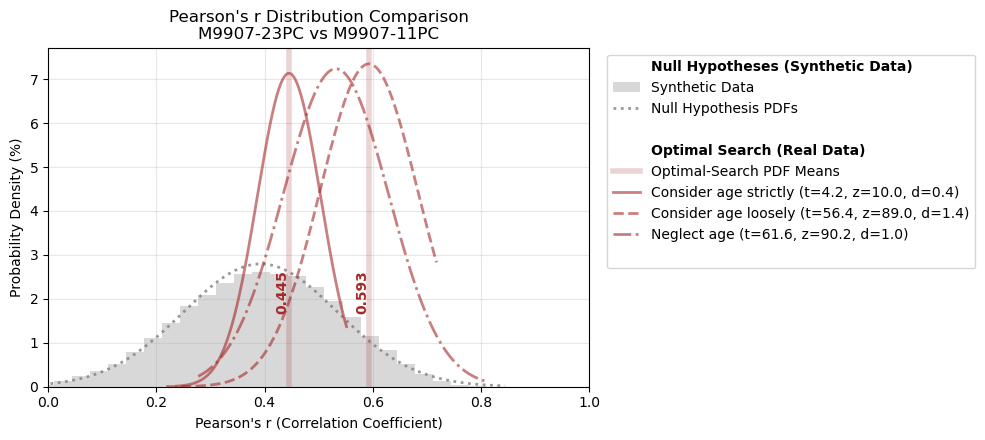


=== DETAILED STATISTICAL ANALYSIS ===
Null Hypothesis Distribution:
  Mean: 0.4, SD: 0.1
  Sample size: 431043
  Interpretation: Baseline distribution from synthetic data representing no true correlation

--- Optimal Search Results ---
Consider age strictly:
  Mean: 0.4, SD: 0.1
  t-statistic: 4.2 (measures difference between means relative to variation)
  z-statistic: 10.0 (standard deviations from null hypothesis mean)
  p-value: 2.9e-05
  Cohen's d: 0.4
  Sample size: 130
  Effect size: small difference between distributions
  Interpretation: Significantly higher than null hypothesis with small effect size

Consider age loosely:
  Mean: 0.6, SD: 0.1
  t-statistic: 56.4 (measures difference between means relative to variation)
  z-statistic: 89.0 (standard deviations from null hypothesis mean)
  p-value: 0
  Cohen's d: 1.4
  Sample size: 1621
  Effect size: large difference between distributions
  Interpretation: Significantly higher than null hypothesis with large effect size

Negl

In [ ]:
# Now create combined plot from master CSV
print("\n--- Creating combined distribution plot ---")

# Load all fit_params from master CSV
master_csv_filename = f'outputs/r-values_fit_params_{CORE_A}_{CORE_B}.csv'
df_all_params = pd.read_csv(master_csv_filename)

# Define which categories to load - you can customize these filters
load_filters = {
    'age_consideration': [True, False],  # Load both True and False, or specify [True] for only True
    'restricted_age_correlation': [True, False, None],  # Load both True, False, and empty/NaN values
    # 'shortest_path_search': [True, False]  # Load both, or specify [True] for only optimal search
    'shortest_path_search': [True]  # Load both, or specify [True] for only optimal search
}

# Apply filters with NaN handling
mask = pd.Series([True] * len(df_all_params))
for column, values in load_filters.items():
    if values is not None:  # Allow None to skip filtering on that parameter
        # Handle NaN/empty values in the filter
        if None in values:
            # Include rows where the column is NaN or in the specified values
            mask &= (df_all_params[column].isin([v for v in values if v is not None]) | 
                    df_all_params[column].isna())
        else:
            # Only include non-NaN values that match the filter
            mask &= df_all_params[column].isin(values)

df_all_params = df_all_params[mask]
print(f"Loaded {len(df_all_params)} rows after filtering")

# Show what combinations were loaded (handle NaN display)
print("Loaded parameter combinations:")
loaded_combos = df_all_params.groupby(['age_consideration', 'restricted_age_correlation', 'shortest_path_search'], dropna=False).size().reset_index(name='count')
for idx, row in loaded_combos.iterrows():
    restricted_val = row['restricted_age_correlation'] if pd.notna(row['restricted_age_correlation']) else 'None/Empty'
    print(f"  age_consideration={row['age_consideration']}, restricted_age_correlation={restricted_val}, shortest_path_search={row['shortest_path_search']} ({row['count']} rows)")

#####

# Load synthetic fit params from CSV for background
synthetic_csv_filename = 'outputs/synthetic_fit_params_MSonly.csv'
df_synthetic_params = pd.read_csv(synthetic_csv_filename)

# Reconstruct combined data from binned data (same as file_context_0)
all_raw_data = []

# Process each iteration to reconstruct raw data from binned data
for _, row in df_synthetic_params.iterrows():
    # Extract binned data
    bins = np.fromstring(row['bins'].strip('[]'), sep=' ') if 'bins' in row and pd.notna(row['bins']) else None
    hist_percentages = np.fromstring(row['hist'].strip('[]'), sep=' ') if 'hist' in row and pd.notna(row['hist']) else None
    n_points = row['n_points'] if 'n_points' in row and pd.notna(row['n_points']) else None
    
    if bins is not None and hist_percentages is not None and n_points is not None:
        # Convert percentages back to raw counts
        raw_counts = (hist_percentages * n_points) / 100
        
        # Reconstruct data points by sampling from each bin
        bin_centers = (bins[:-1] + bins[1:]) / 2
        bin_width = bins[1] - bins[0]
        
        for i, count in enumerate(raw_counts):
            if count > 0:
                # Generate random points within each bin
                n_samples = int(round(count))
                if n_samples > 0:
                    # Sample uniformly within the bin
                    bin_samples = np.random.uniform(
                        bins[i], bins[i+1], n_samples
                    )
                    all_raw_data.extend(bin_samples)

# Convert to numpy array
combined_data = np.array(all_raw_data)

# Fit normal distribution to combined data
from scipy import stats
fitted_mean, fitted_std = stats.norm.fit(combined_data)

# Generate fitted curve
x_fitted = np.linspace(combined_data.min(), combined_data.max(), 1000)
y_fitted = stats.norm.pdf(x_fitted, fitted_mean, fitted_std)

# Function to reconstruct raw data from histogram
def reconstruct_raw_data_from_histogram(bins, hist_percentages, n_points):
    """Reconstruct raw data points from histogram bins and percentages"""
    raw_data = []
    
    # Convert percentages to raw counts
    raw_counts = (hist_percentages * n_points) / 100
    
    # Generate data points for each bin
    for i, count in enumerate(raw_counts):
        if count > 0:
            n_samples = int(round(count))
            if n_samples > 0:
                # Sample uniformly within the bin
                bin_samples = np.random.uniform(bins[i], bins[i+1], n_samples)
                raw_data.extend(bin_samples)
    
    return np.array(raw_data)

# Function to calculate Cohen's d
def cohens_d(x, y):
    """Calculate Cohen's d for effect size between two samples"""
    n1, n2 = len(x), len(y)
    s1, s2 = np.std(x, ddof=1), np.std(y, ddof=1)
    # Pooled standard deviation
    s_pooled = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
    # Cohen's d
    d = (np.mean(x) - np.mean(y)) / s_pooled
    return d

# Function to perform z-test
# def z_test(x, y):
#     """Perform z-test comparing sample x against null hypothesis population y"""
#     n_sample = len(x)
#     sample_mean = np.mean(x)
#     null_mean = np.mean(y)
#     null_std = np.std(y, ddof=0)  # Population SD of null hypothesis (ddof=0)
    
#     # Standard error of the sample mean
#     se_sample = null_std / np.sqrt(n_sample)
    
#     # Z-statistic
#     z_stat = (sample_mean - null_mean) / se_sample
    
#     return z_stat

# Create combined plot
fig, ax = plt.subplots(figsize=(10, 4.5))

# Define colors and line styles
solid_color = 'brown'
dash_color = 'green'
# Different line patterns for differentiation within same color group
solid_line_patterns = ['-', '--', '-.']  # solid, dash-dot, dotted for brown group
dash_line_patterns = ['-', '--', '-.']  # different dash patterns for green group

# Plot combined histogram in gray bars (same style as file_context_0)
n_bins = 30
ax.hist(combined_data, bins=n_bins, alpha=0.3, color='gray', density=True, label='Synthetic Data')

# Plot fitted normal curve as gray dotted line (same style as original synthetic curves)
ax.plot(x_fitted, y_fitted, color='gray', linestyle=':', linewidth=2, alpha=0.8,
        label='Null Hypothesis PDFs')

# Get unique combinations available in the CSV
unique_combinations = df_all_params.drop_duplicates(
    subset=['age_consideration', 'restricted_age_correlation', 'shortest_path_search']
)[['age_consideration', 'restricted_age_correlation', 'shortest_path_search']].to_dict('records')

print(f"Found {len(unique_combinations)} unique parameter combinations in CSV:")
for combo in unique_combinations:
    print(f"  {combo}")

# Separate combinations by search method and collect mean values
optimal_combinations = []  # For brown group (shortest_path_search=True)
random_combinations = []   # For green group (shortest_path_search=False)

solid_mean_values = []  # For optimal search group
dash_mean_values = []   # For random search group

for combo in unique_combinations:
    combo_data = df_all_params[
        (df_all_params['age_consideration'] == combo['age_consideration']) &
        (df_all_params['restricted_age_correlation'] == combo['restricted_age_correlation']) &
        (df_all_params['shortest_path_search'] == combo['shortest_path_search'])
    ]
    
    combo_mean_values = []
    for idx, row in combo_data.iterrows():
        if 'mean' in row and pd.notna(row['mean']):
            combo_mean_values.append(row['mean'])
    
    # Determine which search method group this combination belongs to
    if combo['shortest_path_search']:
        optimal_combinations.append(combo)
        solid_mean_values.extend(combo_mean_values)
    else:
        random_combinations.append(combo)
        dash_mean_values.extend(combo_mean_values)

# Plot vertical lines for each search method group with text labels
solid_mean_plotted = False
dash_mean_plotted = False

if solid_mean_values:
    for mean_val in solid_mean_values:
        label = 'Optimal-Search PDF Means' if not solid_mean_plotted else ""
        ax.axvline(x=mean_val, color=solid_color, alpha=0.2, linewidth=4, label=label)
        # Add text label for mean value
        ax.text(mean_val, ax.get_ylim()[1] * 0.9, f'{mean_val:.3f}', 
                rotation=90, ha='right', va='top', color=solid_color, fontweight='bold')
        solid_mean_plotted = True

if dash_mean_values:
    for mean_val in dash_mean_values:
        label = 'Random-Search PDF Means' if not dash_mean_plotted else ""
        ax.axvline(x=mean_val, color=dash_color, alpha=0.2, linewidth=4, label=label)
        # Add text label for mean value
        ax.text(mean_val, ax.get_ylim()[1] * 0.9, f'{mean_val:.3f}', 
                rotation=90, ha='right', va='top', color=dash_color, fontweight='bold')
        dash_mean_plotted = True

# Collect real data for statistical tests - separate by individual distributions
solid_real_data_by_combo = {}  # Dictionary to store data by combination
dash_real_data_by_combo = {}

# Plot each distribution curve and collect data for statistical tests
solid_count = 0
dash_count = 0

for idx, row in df_all_params.iterrows():
    # Extract parameter values directly from CSV columns
    age_consideration = row['age_consideration']
    restricted_age_correlation = row['restricted_age_correlation']
    shortest_path_search = row['shortest_path_search']
    
    # Parse x_range and y_values from stored strings
    if 'x_range' in row and 'y_values' in row and pd.notna(row['x_range']) and pd.notna(row['y_values']):
        try:
            x_range = np.fromstring(row['x_range'].strip('[]'), sep=' ')
            y_values = np.fromstring(row['y_values'].strip('[]'), sep=' ')
            
            # Create unique key for this parameter combination
            combo_key = f"age_{age_consideration}_restricted_{restricted_age_correlation}_shortest_{shortest_path_search}"
            
            # Reconstruct raw data from histogram for statistical tests
            if 'bins' in row and 'hist' in row and 'n_points' in row and \
               pd.notna(row['bins']) and pd.notna(row['hist']) and pd.notna(row['n_points']):
                
                bins = np.fromstring(row['bins'].strip('[]'), sep=' ')
                hist_percentages = np.fromstring(row['hist'].strip('[]'), sep=' ')
                n_points = row['n_points']
                
                # Reconstruct raw data points
                raw_data_points = reconstruct_raw_data_from_histogram(bins, hist_percentages, n_points)
                
                # Group by search method based on shortest_path_search column
                if shortest_path_search:
                    if combo_key not in solid_real_data_by_combo:
                        solid_real_data_by_combo[combo_key] = []
                    solid_real_data_by_combo[combo_key].extend(raw_data_points)
                else:
                    if combo_key not in dash_real_data_by_combo:
                        dash_real_data_by_combo[combo_key] = []
                    dash_real_data_by_combo[combo_key].extend(raw_data_points)
            
            if len(x_range) > 0 and len(y_values) > 0:
                # Create descriptive label based on parameter combination
                # Determine age treatment description
                if age_consideration:
                    if restricted_age_correlation:
                        age_desc = "Consider age strictly"
                    else:
                        age_desc = "Consider age loosely"
                else:
                    age_desc = "Neglect age"
                
                # Create label without mean value
                label = f'{age_desc}'
                
                # Determine color and line pattern based on shortest_path_search
                if shortest_path_search:
                    color = solid_color
                    line_pattern = solid_line_patterns[solid_count % len(solid_line_patterns)]
                    solid_count += 1
                else:
                    color = dash_color
                    line_pattern = dash_line_patterns[dash_count % len(dash_line_patterns)]
                    dash_count += 1
                
                # Plot distribution curve
                ax.plot(x_range, y_values, 
                       color=color, 
                       linestyle=line_pattern,
                       linewidth=2, alpha=0.6, 
                       label=label)
        
        except Exception as e:
            print(f"Warning: Could not plot curve for row {idx}: {str(e)}")

# Perform statistical tests for each individual distribution
solid_stats_by_combo = {}
dash_stats_by_combo = {}

# Calculate statistics for solid (optimal search) combinations
for combo_key, data in solid_real_data_by_combo.items():
    if len(data) > 1:  # Need at least 2 data points for statistical tests
        data_array = np.array(data)
        t_stat, p_value = stats.ttest_ind(data_array, combined_data)
        
        # Replace z_test with one-sample t-test but keep variable name as z_stat
        null_mean = np.mean(combined_data)
        z_stat, _ = stats.ttest_1samp(data_array, null_mean)
        
        cohens_d_val = cohens_d(data_array, combined_data)
        
        solid_stats_by_combo[combo_key] = {
            't_stat': t_stat,
            'p_value': p_value,
            'z_stat': z_stat,  # This is actually a one-sample t-stat now
            'cohens_d': cohens_d_val,
            'n_samples': len(data_array),
            'mean': np.mean(data_array),
            'std': np.std(data_array)
        }

# Calculate statistics for dash (random search) combinations
for combo_key, data in dash_real_data_by_combo.items():
    if len(data) > 1:  # Need at least 2 data points for statistical tests
        data_array = np.array(data)
        t_stat, p_value = stats.ttest_ind(data_array, combined_data)
        
        # Replace z_test with one-sample t-test but keep variable name as z_stat
        null_mean = np.mean(combined_data)
        z_stat, _ = stats.ttest_1samp(data_array, null_mean)
        
        cohens_d_val = cohens_d(data_array, combined_data)
        
        dash_stats_by_combo[combo_key] = {
            't_stat': t_stat,
            'p_value': p_value,
            'z_stat': z_stat,  # This is actually a one-sample t-stat now
            'cohens_d': cohens_d_val,
            'n_samples': len(data_array),
            'mean': np.mean(data_array),
            'std': np.std(data_array)
        }

# Formatting
ax.set_xlabel("Pearson's r (Correlation Coefficient)")
ax.set_ylabel('Probability Density (%)')
ax.set_title(f'Pearson\'s r Distribution Comparison\n{CORE_A} vs {CORE_B}')

# Create grouped legend
handles, labels = ax.get_legend_handles_labels()

# Separate handles and labels by groups
synthetic_handles = []
synthetic_labels = []
red_group_handles = []
red_group_labels = []
blue_group_handles = []
blue_group_labels = []

for handle, label in zip(handles, labels):
    if 'Null' in label or 'Synthetic' in label:
        synthetic_handles.append(handle)
        synthetic_labels.append(label)
    elif (hasattr(handle, 'get_color') and handle.get_color() == solid_color) or \
         (hasattr(handle, 'get_facecolor') and handle.get_facecolor() == solid_color) or \
         'Optimal' in label:
        red_group_handles.append(handle)
        red_group_labels.append(label)
    elif (hasattr(handle, 'get_color') and handle.get_color() == dash_color) or \
         (hasattr(handle, 'get_facecolor') and handle.get_facecolor() == dash_color) or \
         'Random' in label:
        blue_group_handles.append(handle)
        blue_group_labels.append(label)

# Create grouped legend with titles and detailed statistics

legend_elements = []
legend_labels = []

# Add synthetic group
if synthetic_handles:
    # Add group title (invisible line)
    legend_elements.append(Line2D([0], [0], color='white', linewidth=0, alpha=0))
    legend_labels.append('Null Hypotheses (Synthetic Data)')
    # Add actual legend items
    legend_elements.extend(synthetic_handles)
    legend_labels.extend(synthetic_labels)
    # Add spacer
    legend_elements.append(Line2D([0], [0], color='white', linewidth=0, alpha=0))
    legend_labels.append('')

# Add red group with individual statistics
if red_group_handles:
    # Add group title (invisible line)
    legend_elements.append(Line2D([0], [0], color='white', linewidth=0, alpha=0))
    legend_labels.append('Optimal Search (Real Data)')
    
    # Add individual legend items with their statistics
    for handle, label in zip(red_group_handles, red_group_labels):
        legend_elements.append(handle)
        
        # Find corresponding combo_key for this label
        combo_stats = None
        for combo_key, stats_dict in solid_stats_by_combo.items():
            # Parse combo_key to match with label
            if "age_True_restricted_True" in combo_key and label == "Consider age strictly":
                combo_stats = stats_dict
                break
            elif "age_True_restricted_False" in combo_key and label == "Consider age loosely":
                combo_stats = stats_dict
                break
            elif "age_False" in combo_key and label == "Neglect age":
                combo_stats = stats_dict
                break
        
        if combo_stats:
            enhanced_label = f"{label} (t={combo_stats['t_stat']:.1f}, z={combo_stats['z_stat']:.1f}, d={combo_stats['cohens_d']:.1f})"
        else:
            enhanced_label = label
        
        legend_labels.append(enhanced_label)
    
    # Add spacer
    legend_elements.append(Line2D([0], [0], color='white', linewidth=0, alpha=0))
    legend_labels.append('')

# Add blue group with individual statistics
if blue_group_handles:
    # Add group title (invisible line)
    legend_elements.append(Line2D([0], [0], color='white', linewidth=0, alpha=0))
    legend_labels.append('Random Search (Real Data)')
    
    # Add individual legend items with their statistics
    for handle, label in zip(blue_group_handles, blue_group_labels):
        legend_elements.append(handle)
        
        # Find corresponding combo_key for this label
        combo_stats = None
        for combo_key, stats_dict in dash_stats_by_combo.items():
            # Parse combo_key to match with label
            if "age_True_restricted_True" in combo_key and label == "Consider age strictly":
                combo_stats = stats_dict
                break
            elif "age_True_restricted_False" in combo_key and label == "Consider age loosely":
                combo_stats = stats_dict
                break
            elif "age_False" in combo_key and label == "Neglect age":
                combo_stats = stats_dict
                break
        
        if combo_stats:
            enhanced_label = f"{label} (t={combo_stats['t_stat']:.1f}, z={combo_stats['z_stat']:.1f}, d={combo_stats['cohens_d']:.1f})"
        else:
            enhanced_label = label
        
        legend_labels.append(enhanced_label)

# Apply legend with grouping
legend = ax.legend(legend_elements, legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left')

# Style the group title labels
for i, label in enumerate(legend_labels):
    if label.startswith('Null Hypotheses') or label.startswith('Optimal Search') or label.startswith('Random Search'):
        legend.get_texts()[i].set_weight('bold')
        legend.get_texts()[i].set_fontsize(10)
        legend.get_texts()[i].set_ha('left')  # Align to left

ax.grid(True, alpha=0.3)
ax.set_xlim(0, 1.0)

plt.tight_layout()
plt.savefig(f'outputs/r-values_comparison_{CORE_A}_{CORE_B}.png', dpi=150, bbox_inches='tight')
plt.show()

# Print detailed statistical results
print(f"\n=== DETAILED STATISTICAL ANALYSIS ===")
print(f"Null Hypothesis Distribution:")
print(f"  Mean: {fitted_mean:.1f}, SD: {fitted_std:.1f}")
print(f"  Sample size: {len(combined_data)}")
print(f"  Interpretation: Baseline distribution from synthetic data representing no true correlation")
print()

print(f"--- Optimal Search Results ---")
for combo_key, stats in solid_stats_by_combo.items():
    # Parse combo_key to get descriptive name
    if "age_True_restricted_True" in combo_key:
        desc = "Consider age strictly"
    elif "age_True_restricted_False" in combo_key:
        desc = "Consider age loosely"
    elif "age_False" in combo_key:
        desc = "Neglect age"
    else:
        desc = combo_key
    
    print(f"{desc}:")
    print(f"  Mean: {stats['mean']:.1f}, SD: {stats['std']:.1f}")
    print(f"  t-statistic: {stats['t_stat']:.1f} (measures difference between means relative to variation)")
    print(f"  z-statistic: {stats['z_stat']:.1f} (standard deviations from null hypothesis mean)")
    print(f"  p-value: {stats['p_value']:.2g}")
    print(f"  Cohen's d: {stats['cohens_d']:.1f}")
    print(f"  Sample size: {stats['n_samples']}")
    
    # Interpret effect size
    if abs(stats['cohens_d']) < 0.2:
        effect_size = "negligible"
    elif abs(stats['cohens_d']) < 0.5:
        effect_size = "small"
    elif abs(stats['cohens_d']) < 0.8:
        effect_size = "medium"
    else:
        effect_size = "large"
    
    # Statistical interpretation
    if stats['t_stat'] > 0:
        direction = "higher than"
    else:
        direction = "lower than"
    
    print(f"  Effect size: {effect_size} difference between distributions")
    
    # Only use "significantly" if p-value indicates statistical significance
    if stats['p_value'] < 0.05:
        print(f"  Interpretation: Significantly {direction} null hypothesis with {effect_size} effect size")
    else:
        print(f"  Interpretation: no statistical significance (p-value = {stats['p_value']:.2e})")
    print()
    

print(f"--- Random Search Results ---")
for combo_key, stats in dash_stats_by_combo.items():
    # Parse combo_key to get descriptive name
    if "age_True_restricted_True" in combo_key:
        desc = "Consider age strictly"
    elif "age_True_restricted_False" in combo_key:
        desc = "Consider age loosely"
    elif "age_False" in combo_key:
        desc = "Neglect age"
    else:
        desc = combo_key
    
    print(f"{desc}:")
    print(f"  Mean: {stats['mean']:.1f}, SD: {stats['std']:.1f}")
    print(f"  t-statistic: {stats['t_stat']:.1f} (measures difference between means relative to variation)")
    print(f"  z-statistic: {stats['z_stat']:.1f} (standard deviations from null hypothesis mean)")
    print(f"  p-value: {stats['p_value']:.2g}")
    print(f"  Cohen's d: {stats['cohens_d']:.1f}")
    print(f"  Sample size: {stats['n_samples']}")
    
    # Interpret effect size
    if abs(stats['cohens_d']) < 0.2:
        effect_size = "negligible"
    elif abs(stats['cohens_d']) < 0.5:
        effect_size = "small"
    elif abs(stats['cohens_d']) < 0.8:
        effect_size = "medium"
    else:
        effect_size = "large"
    
    # Statistical interpretation
    if stats['t_stat'] > 0:
        direction = "higher than"
    else:
        direction = "lower than"
    
    print(f"  Effect size: {effect_size} difference between distributions")
    
    # Only use "significantly" if p-value indicates statistical significance
    if stats['p_value'] < 0.05:
        print(f"  Interpretation: Significantly {direction} null hypothesis with {effect_size} effect size")
    else:
        print(f"  Interpretation: no statistical significance (p-value = {stats['p_value']:.2e})")
    print()


print(f"\n✓ Combined plot saved as: outputs/r-values_comparison_{CORE_A}_{CORE_B}.png")
print(f"✓ Analysis complete!")